# Описание проекта
### Телеком — задача проекта

Оператор связи «Ниединогоразрыва.ком» хочет научиться прогнозировать отток клиентов. Если выяснится, что пользователь планирует уйти, ему будут предложены промокоды и специальные условия. Команда оператора собрала персональные данные о некоторых клиентах, информацию об их тарифах и договорах.

### Описание услуг

Оператор предоставляет два основных типа услуг: 

1. Стационарную телефонную связь. Возможно подключение телефонного аппарата к нескольким линиям одновременно.
2. Интернет. Подключение может быть двух типов: через телефонную линию (DSL*,* от англ. *digital subscriber line*, «цифровая абонентская линия») или оптоволоконный кабель (*Fiber optic*).  

Также доступны такие услуги:

- Интернет-безопасность: антивирус (*DeviceProtection*) и блокировка небезопасных сайтов (*OnlineSecurity*);
- Выделенная линия технической поддержки (*TechSupport*);
- Облачное хранилище файлов для резервного копирования данных (*OnlineBackup*);
- Стриминговое телевидение (*StreamingTV*) и каталог фильмов (*StreamingMovies*).

За услуги клиенты могут платить каждый месяц или заключить договор на 1–2 года. Доступны различные способы расчёта и возможность получения электронного чека.

### Описание данных

Данные состоят из файлов, полученных из разных источников:

- `contract.csv` — информация о договоре;
- `personal.csv` — персональные данные клиента;
- `internet.csv` — информация об интернет-услугах;
- `phone.csv` — информация об услугах телефонии.

Во всех файлах столбец `customerID` содержит код клиента.

Информация о договорах актуальна на 1 февраля 2020.

## Изучение данных

In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import roc_auc_score, roc_curve, accuracy_score
from sklearn.utils import shuffle

from sklearn.preprocessing import StandardScaler

from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from catboost import CatBoostClassifier

from collections import namedtuple

In [2]:
df_contract = pd.read_csv('/datasets/final_provider/contract.csv')
df_personal = pd.read_csv('/datasets/final_provider/personal.csv')
df_internet = pd.read_csv('/datasets/final_provider/internet.csv')
df_phone = pd.read_csv('/datasets/final_provider/phone.csv')

In [3]:
def show_info(df):
    rows, columns = df.shape
    print('Количество строк:', rows)
    print('Количество стобцов:', columns)
    display(df.head(15))
    display(df.info())
    display(df.describe())
    
def show_rows(df):
    for column in df.columns:
        if column not in('BeginDate', 'EndDate','customerID'):
            print('Уникальные значения столбца', column)
            print(df[column].value_counts())
            print()

### Информация о договоре

In [4]:
show_info(df_contract)

Количество строк: 7043
Количество стобцов: 8


,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65
5,9305-CDSKC,2019-03-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,99.65,820.5
6,1452-KIOVK,2018-04-01,No,Month-to-month,Yes,Credit card (automatic),89.10,1949.4
7,6713-OKOMC,2019-04-01,No,Month-to-month,No,Mailed check,29.75,301.9
8,7892-POOKP,2017-07-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,104.80,3046.05
9,6388-TABGU,2014-12-01,No,One year,No,Bank transfer (automatic),56.15,3487.95


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
customerID          7043 non-null object
BeginDate           7043 non-null object
EndDate             7043 non-null object
Type                7043 non-null object
PaperlessBilling    7043 non-null object
PaymentMethod       7043 non-null object
MonthlyCharges      7043 non-null float64
TotalCharges        7043 non-null object
dtypes: float64(1), object(7)
memory usage: 440.3+ KB


None

,MonthlyCharges
count,7043.000000
mean,64.761692
std,30.090047
min,18.250000
25%,35.500000
50%,70.350000
75%,89.850000
max,118.750000


In [5]:
show_rows(df_contract)

Уникальные значения столбца Type
Month-to-month    3875
Two year          1695
One year          1473
Name: Type, dtype: int64

Уникальные значения столбца PaperlessBilling
Yes    4171
No     2872
Name: PaperlessBilling, dtype: int64

Уникальные значения столбца PaymentMethod
Electronic check             2365
Mailed check                 1612
Bank transfer (automatic)    1544
Credit card (automatic)      1522
Name: PaymentMethod, dtype: int64

Уникальные значения столбца MonthlyCharges
20.05     61
19.85     45
19.95     44
19.90     44
20.00     43
          ..
114.75     1
103.60     1
113.40     1
57.65      1
113.30     1
Name: MonthlyCharges, Length: 1585, dtype: int64

Уникальные значения столбца TotalCharges
           11
20.2       11
19.75       9
19.65       8
19.9        8
           ..
5867        1
5883.85     1
4068        1
3414.65     1
6287.25     1
Name: TotalCharges, Length: 6531, dtype: int64



### Персональные данные клиента

In [6]:
show_info(df_personal)

Количество строк: 7043
Количество стобцов: 5


,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No
5,9305-CDSKC,Female,0,No,No
6,1452-KIOVK,Male,0,No,Yes
7,6713-OKOMC,Female,0,No,No
8,7892-POOKP,Female,0,Yes,No
9,6388-TABGU,Male,0,No,Yes


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
customerID       7043 non-null object
gender           7043 non-null object
SeniorCitizen    7043 non-null int64
Partner          7043 non-null object
Dependents       7043 non-null object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


None

,SeniorCitizen
count,7043.000000
mean,0.162147
std,0.368612
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,1.000000


In [7]:
show_rows(df_personal)

Уникальные значения столбца gender
Male      3555
Female    3488
Name: gender, dtype: int64

Уникальные значения столбца SeniorCitizen
0    5901
1    1142
Name: SeniorCitizen, dtype: int64

Уникальные значения столбца Partner
No     3641
Yes    3402
Name: Partner, dtype: int64

Уникальные значения столбца Dependents
No     4933
Yes    2110
Name: Dependents, dtype: int64



###  Информация об интернет-услугах

In [8]:
show_info(df_internet)

Количество строк: 5517
Количество стобцов: 8


,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No
5,9305-CDSKC,Fiber optic,No,No,Yes,No,Yes,Yes
6,1452-KIOVK,Fiber optic,No,Yes,No,No,Yes,No
7,6713-OKOMC,DSL,Yes,No,No,No,No,No
8,7892-POOKP,Fiber optic,No,No,Yes,Yes,Yes,Yes
9,6388-TABGU,DSL,Yes,Yes,No,No,No,No


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
customerID          5517 non-null object
InternetService     5517 non-null object
OnlineSecurity      5517 non-null object
OnlineBackup        5517 non-null object
DeviceProtection    5517 non-null object
TechSupport         5517 non-null object
StreamingTV         5517 non-null object
StreamingMovies     5517 non-null object
dtypes: object(8)
memory usage: 344.9+ KB


None

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
count,5517,5517,5517,5517,5517,5517,5517,5517
unique,5517,2,2,2,2,2,2,2
top,4548-SDBKE,Fiber optic,No,No,No,No,No,No
freq,1,3096,3498,3088,3095,3473,2810,2785


In [9]:
show_rows(df_internet)

Уникальные значения столбца InternetService
Fiber optic    3096
DSL            2421
Name: InternetService, dtype: int64

Уникальные значения столбца OnlineSecurity
No     3498
Yes    2019
Name: OnlineSecurity, dtype: int64

Уникальные значения столбца OnlineBackup
No     3088
Yes    2429
Name: OnlineBackup, dtype: int64

Уникальные значения столбца DeviceProtection
No     3095
Yes    2422
Name: DeviceProtection, dtype: int64

Уникальные значения столбца TechSupport
No     3473
Yes    2044
Name: TechSupport, dtype: int64

Уникальные значения столбца StreamingTV
No     2810
Yes    2707
Name: StreamingTV, dtype: int64

Уникальные значения столбца StreamingMovies
No     2785
Yes    2732
Name: StreamingMovies, dtype: int64



### Информация об услугах телефонии

In [10]:
show_info(df_phone)

Количество строк: 6361
Количество стобцов: 2


,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes
5,7892-POOKP,Yes
6,6388-TABGU,No
7,9763-GRSKD,No
8,7469-LKBCI,No
9,8091-TTVAX,Yes


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
customerID       6361 non-null object
MultipleLines    6361 non-null object
dtypes: object(2)
memory usage: 99.5+ KB


None

,customerID,MultipleLines
count,6361,6361
unique,6361,2
top,4548-SDBKE,No
freq,1,3390


In [11]:
show_rows(df_phone)

Уникальные значения столбца MultipleLines
No     3390
Yes    2971
Name: MultipleLines, dtype: int64



### Выводы по знакомству с данными

#### Информация о договоре
1. В данных отсутствуют пропуски;
2. Значение 'No' в столбце EndDate говорит о том, что клиент действующий. Это будет являться целевым признаком;
3. TotalCharges необходимо перевести в числовой тип;

#### Персональные данные клиента
1. В данных отсутствуют пропуски;
2. Столбцы gender и Partner переведем в числовой тип.

#### Информация об интернет-услугах
1. В данных отсутствуют пропуски;
2. Столбцы InternetService, OnlineSecurity, OnlineBackup, DeviceProtection, TechSupport, StreamingTV, StreamingMovies  переведем в числовой тип.

#### Информация об услугах телефонии
1. В данных отсутствуют пропуски;
4. К столбцу MultipleLines  переведем в числовой тип.

## Предобработка данных

Объединим исходные таблицы в одну общую таблицу

In [12]:
df_all = df_contract \
    .merge(df_personal, how='left', on='customerID') \
    .merge(df_internet, how='left', on='customerID') \
    .merge(df_phone, how='left', on='customerID') 

In [13]:
display(df_all.shape)
display(df_all.head())
display(df_all.info())

(7043, 20)

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85,Female,0,Yes,No,DSL,No,Yes,No,No,No,No,NaN
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5,Male,0,No,No,DSL,Yes,No,Yes,No,No,No,No
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15,Male,0,No,No,DSL,Yes,Yes,No,No,No,No,No
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75,Male,0,No,No,DSL,Yes,No,Yes,Yes,No,No,NaN
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65,Female,0,No,No,Fiber optic,No,No,No,No,No,No,No


<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 20 columns):
customerID          7043 non-null object
BeginDate           7043 non-null object
EndDate             7043 non-null object
Type                7043 non-null object
PaperlessBilling    7043 non-null object
PaymentMethod       7043 non-null object
MonthlyCharges      7043 non-null float64
TotalCharges        7043 non-null object
gender              7043 non-null object
SeniorCitizen       7043 non-null int64
Partner             7043 non-null object
Dependents          7043 non-null object
InternetService     5517 non-null object
OnlineSecurity      5517 non-null object
OnlineBackup        5517 non-null object
DeviceProtection    5517 non-null object
TechSupport         5517 non-null object
StreamingTV         5517 non-null object
StreamingMovies     5517 non-null object
MultipleLines       6361 non-null object
dtypes: float64(1), int64(1), object(18)
memory usage: 1.1+ MB


None

Проверим на уникальность столбец customerID

In [14]:
df_all['customerID'].is_unique

True

Добавим целевой признак Churn, отражающий факт отказа клиента от услуг.

Если значение в столбце EndDate равно "No" - значит клиент не ушел и целевой признак равен 0.
Если дата ухода есть, то целевой признак равен 1.

In [15]:
df_all["churn"] = (df_all["EndDate"]!="No").astype("int")

Заменим все значения "No" в EndDate на дату выгрузки датасета (01.02.2020) и приведем EndDate и BeginDate к формату даты

In [16]:
df_all['EndDate'] = df_all['EndDate'].replace(['No'], ['2020-02-01'])
print(df_all[df_all['EndDate'] == 'No'].shape[0])

0


In [17]:
df_all['BeginDate'] = pd.to_datetime(df_all['BeginDate'], format='%Y-%m-%d')
df_all['EndDate'] = pd.to_datetime(df_all['EndDate'], format='%Y-%m-%d')

Заведем новый столбец TotalDays, который будет означать, сколько пользователь пользовался услугами

In [18]:
df_all['TotalDays'] = (df_all['EndDate'] - df_all['BeginDate']).dt.days

Столбцы таблиц с информацией об интернет услугах содержат меньшее количество значений. Мне кажется, это связано с тем, что такие клиенты впринцепе не используют данный сервис, поэтому можно заменить эти пропуски на значение 'No'

In [19]:
for col in ["OnlineSecurity", "OnlineBackup", "DeviceProtection", "TechSupport",
            "StreamingTV", "StreamingMovies", "MultipleLines", "InternetService"]:
    df_all[col] = df_all[col].fillna("No")

In [20]:
df_all["TotalCharges"] = pd.to_numeric(df_all["TotalCharges"], errors="coerce").fillna(0.0)

In [21]:
df_all['gender'] = (df_all['gender']=='Male').astype("int")

In [22]:
for col in df_all.select_dtypes("object").columns:
    if sorted(df_all[col].unique())==["No","Yes"]:
        df_all[col] = (df_all[col] == "Yes").astype("int")

In [23]:
display(df_all.sample(2))
display(df_all.info())

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,...,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines,churn,TotalDays
2009,7639-OPLNG,2014-04-01,2020-02-01,Two year,1,Bank transfer (automatic),79.25,5731.85,1,0,...,DSL,1,1,1,1,1,0,1,0,2132
726,4950-HKQTE,2018-04-01,2020-02-01,Two year,0,Mailed check,26.25,605.90,0,0,...,No,0,0,0,0,0,0,1,0,671


<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 22 columns):
customerID          7043 non-null object
BeginDate           7043 non-null datetime64[ns]
EndDate             7043 non-null datetime64[ns]
Type                7043 non-null object
PaperlessBilling    7043 non-null int64
PaymentMethod       7043 non-null object
MonthlyCharges      7043 non-null float64
TotalCharges        7043 non-null float64
gender              7043 non-null int64
SeniorCitizen       7043 non-null int64
Partner             7043 non-null int64
Dependents          7043 non-null int64
InternetService     7043 non-null object
OnlineSecurity      7043 non-null int64
OnlineBackup        7043 non-null int64
DeviceProtection    7043 non-null int64
TechSupport         7043 non-null int64
StreamingTV         7043 non-null int64
StreamingMovies     7043 non-null int64
MultipleLines       7043 non-null int64
churn               7043 non-null int64
TotalDays           7043 no

None

Признаки customerID, EndDate и BeginDate не понадобятся нам для дальнейшего анализа, а при обучении могут только мешать, поэтому создадим новую таблицу df_final на основе df_all, удалив эти признаки

In [24]:
df_final = df_all.drop(["BeginDate","EndDate", "customerID"], axis=1)

In [25]:
df_final.sample(3)

,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines,churn,TotalDays
6372,Two year,0,Credit card (automatic),19.50,96.85,1,0,1,1,No,0,0,0,0,0,0,0,0,123
4612,Two year,0,Mailed check,45.25,2933.95,0,0,0,1,DSL,0,1,0,1,1,0,0,0,1979
6291,One year,0,Credit card (automatic),79.85,4786.10,0,0,0,0,DSL,1,1,1,1,0,1,1,0,1798


#### Вывод по предобработке данных:
По итогу предобработки была имеем таблицу df_final, в которой:
1. Находтся только необходимые для обучения признаки
2. Признаки, имеющие только два значение 'yes' и 'no' и признак gender переведены к типу int
3. Пропуски в столбцах "OnlineSecurity", "OnlineBackup", "DeviceProtection", "TechSupport", "StreamingTV", "StreamingMovies", "MultipleLines", "InternetService" заменены на значение 'No'
4. Определен целевой признак Churn, отражающий факт отказа клиента от услуг

## Исследовательский анализ

Посмотрим на распределение целевого признака:

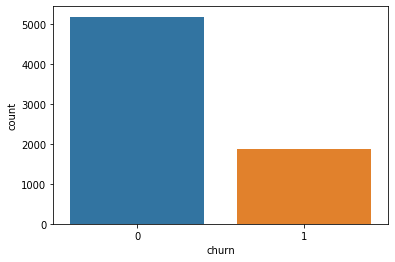

In [27]:
sns.countplot(df_final["churn"]);

Заметен небольшой дисбаланс.

Построим функции, отражающие распределение значений и диаграмму размаха для количественных и категориальных данных

In [28]:
num_col = ['MonthlyCharges', 'TotalCharges', 'TotalDays']
cat_col = ['Type','PaperlessBilling','PaymentMethod', 'gender','SeniorCitizen',
               'Partner','Dependents','InternetService', 'OnlineSecurity', 'OnlineBackup',
               'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'MultipleLines']

def num_plot(df):
    cols = len(num_col)
    rows = 2

    plt.figure(figsize=(20, 10))

    idx = 0
    for column in num_col:
        idx += 1 
    
        plt.subplot(rows, cols, idx)
        plt.hist(df[column])
        plt.title(column)
    
    for column in num_col:
        idx += 1 
    
        plt.subplot(rows, cols, idx)
        plt.boxplot(df[column])
        plt.title(column)
        
    plt.show()

    display(df[num_col].describe())
    
    
def cat_plot(df):
    cols = 2
    rows = int(np.ceil(len(cat_col) / cols))

    plt.figure(figsize=(20, 30))

    for idx, column in enumerate(cat_col):
        df_churn = df.groupby([column, 'churn'])['churn'].count()
        df_churn = df_churn.unstack()

        ax = plt.subplot(rows, cols, idx + 1)

        ax.bar(df_churn.T.index, df_churn.T[df_churn.T.columns[0]], label=df_churn.T.columns[0])
        bottom = np.array(df_churn.T[df_churn.T.columns[0]])
        for color_idx, value in enumerate(df_churn.T.columns[1:]): 
            ax.bar(df_churn.T.index, df_churn.T[value], bottom=bottom, label=value)
            bottom += np.array(df_churn.T[value])
        plt.title(column)
        plt.legend()

    plt.show()

Посмотрим на распределение количественных признаков относительно целевого: 

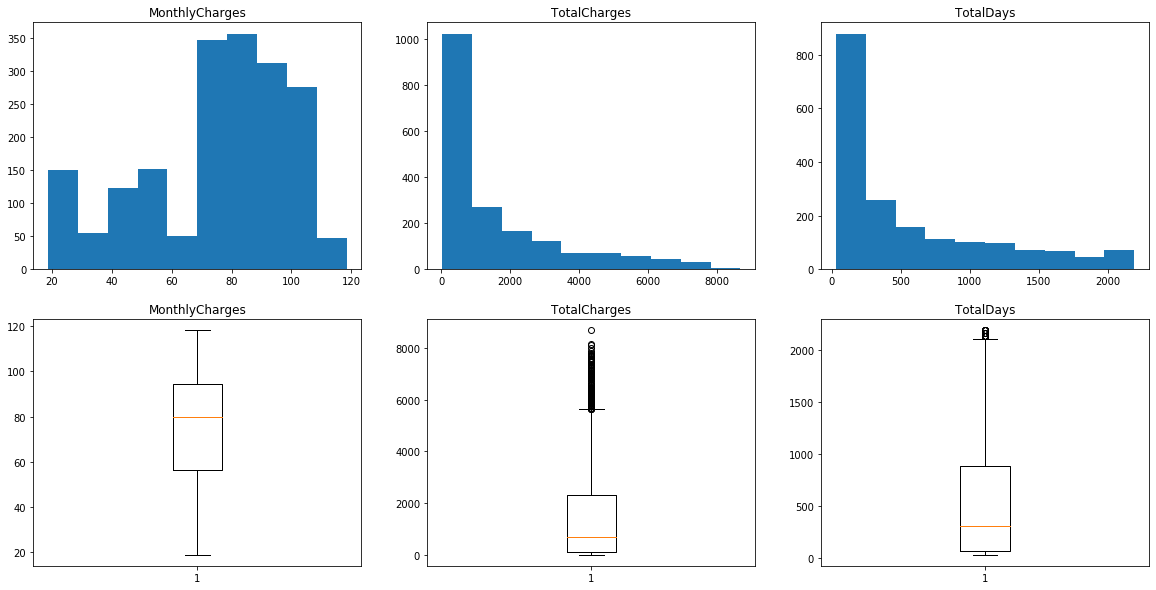

,MonthlyCharges,TotalCharges,TotalDays
count,1869.000000,1869.000000,1869.000000
mean,74.441332,1531.796094,547.352060
std,24.666053,1890.822994,594.389607
min,18.850000,18.850000,30.000000
25%,56.150000,134.500000,61.000000
50%,79.650000,703.550000,304.000000
75%,94.200000,2331.300000,883.000000
max,118.350000,8684.800000,2191.000000


In [29]:
num_plot(df_final[df_final['churn']==1])

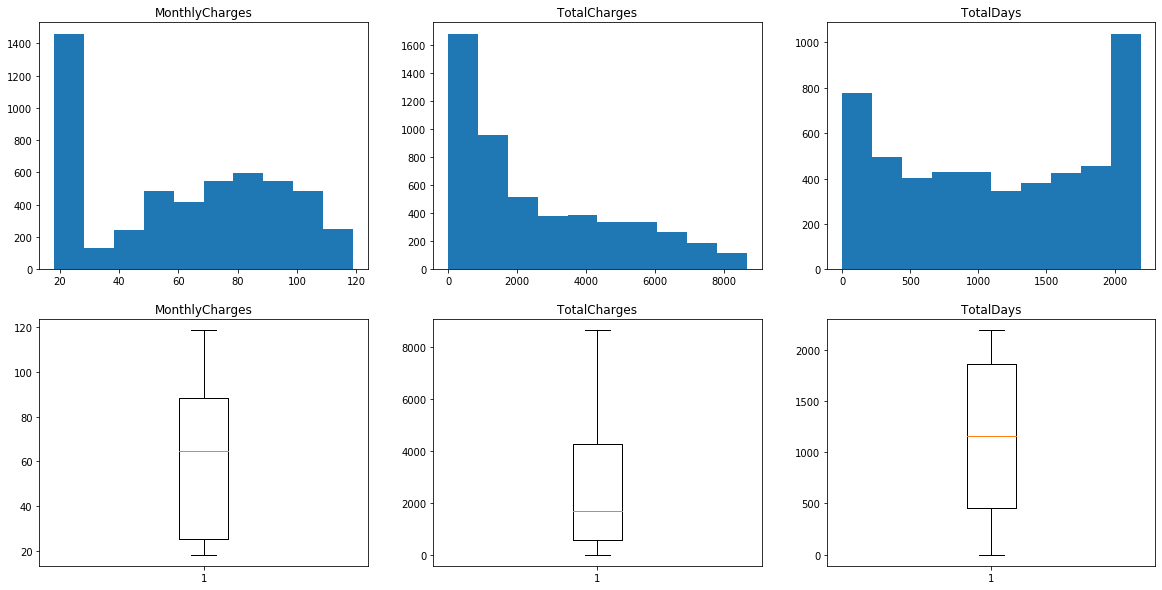

,MonthlyCharges,TotalCharges,TotalDays
count,5174.000000,5174.000000,5174.000000
mean,61.265124,2549.911442,1144.447236
std,31.092648,2329.954215,733.897937
min,18.250000,0.000000,0.000000
25%,25.100000,572.900000,457.000000
50%,64.425000,1679.525000,1157.000000
75%,88.400000,4262.850000,1857.000000
max,118.750000,8672.450000,2191.000000


In [30]:
num_plot(df_final[df_final['churn']==0])

- на рспределении признака MonthlyCharges заметны 3 пика в районе 20, 50 и 80, но самый высокий пик принадлежит минимальному ежемесячному платежу
- распределение у TotalCharges так же отличается пиком на минимальном значении, с увеличением суммы количество значений уменьшается

Посмотрим на распределение категориальных признаков относительно целевого: 

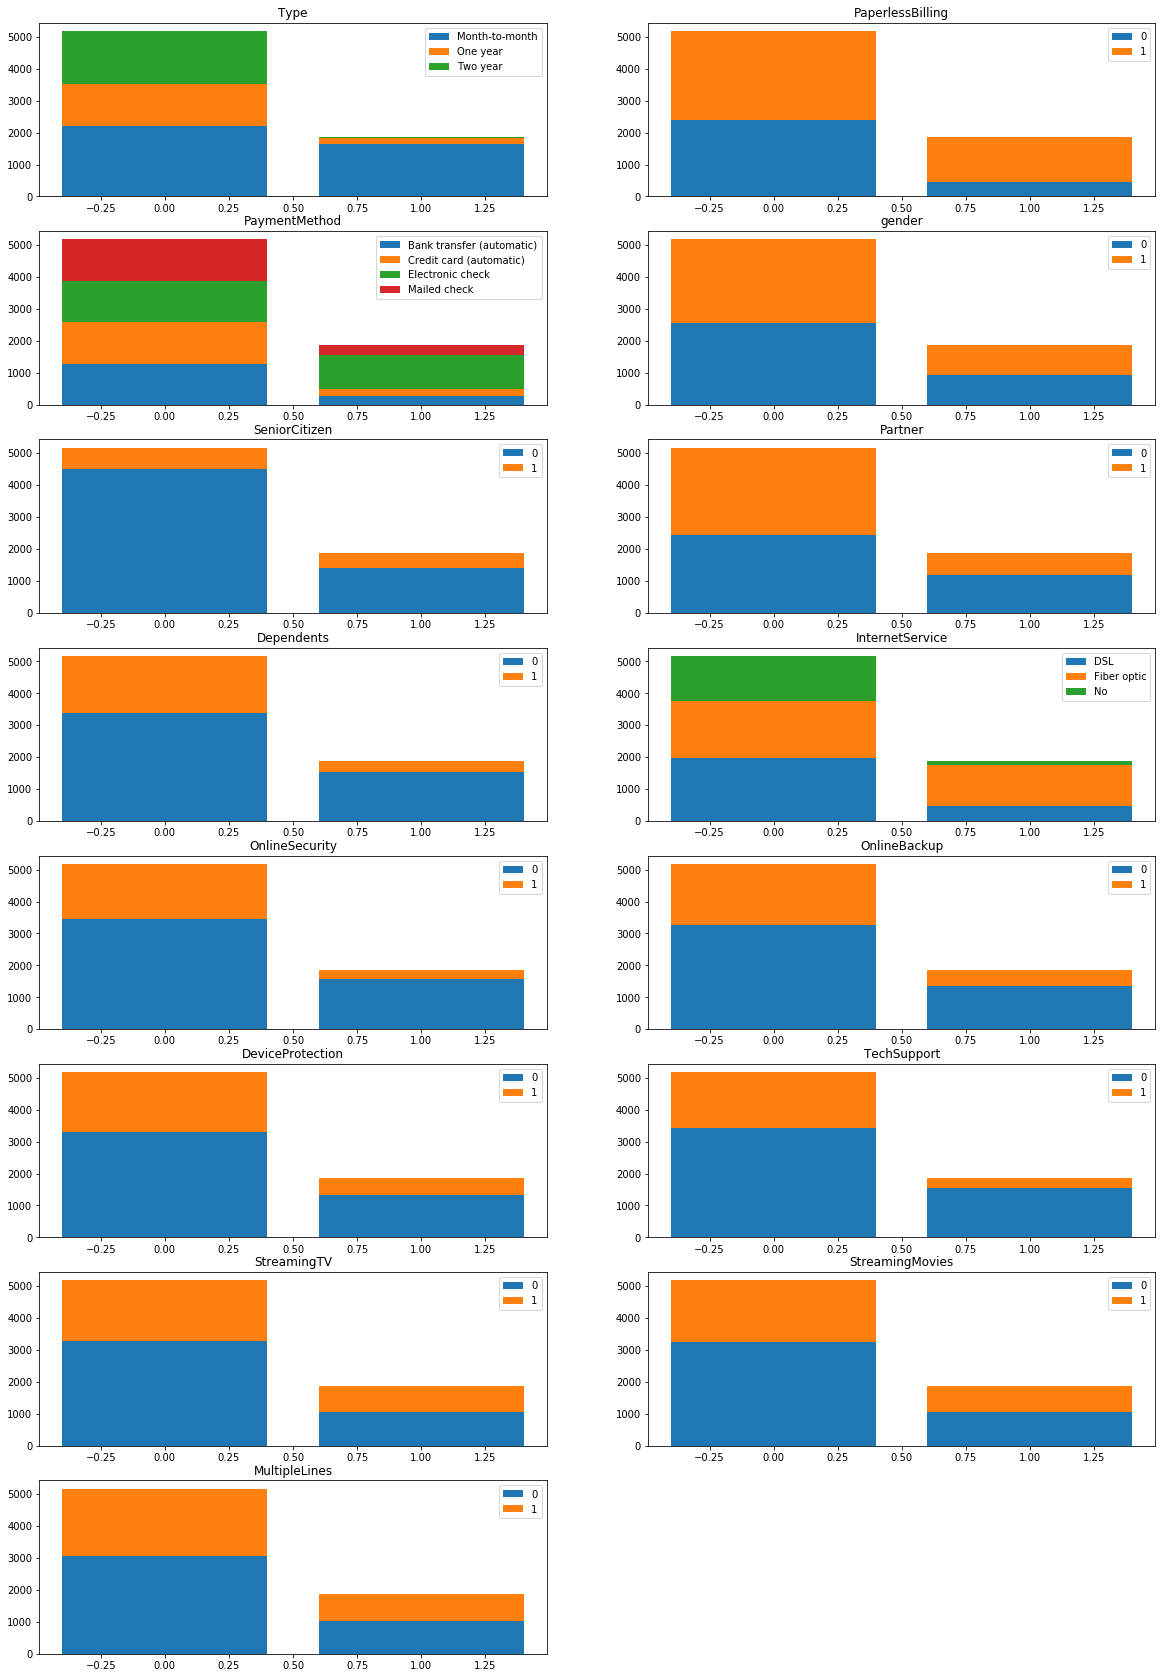

In [31]:
cat_plot(df_final)

- Дополнительные услуги не существенно влияют на отток клиентов. Клиенты уходят примерно в равном соотношении
- Клиенты, пользующиеся электронными чеками покидают сервис чаще. Возможно с функцией отправки электронных чеков есть какие-то проблемы
- Клиенты, которые не пользуются интернетом, уходят реже
- Недавние клиенты (Month-to-month) имеют бОльшую склонность к оттоку

Теперь посмотрим на корреляцию признаков относительно целевого:

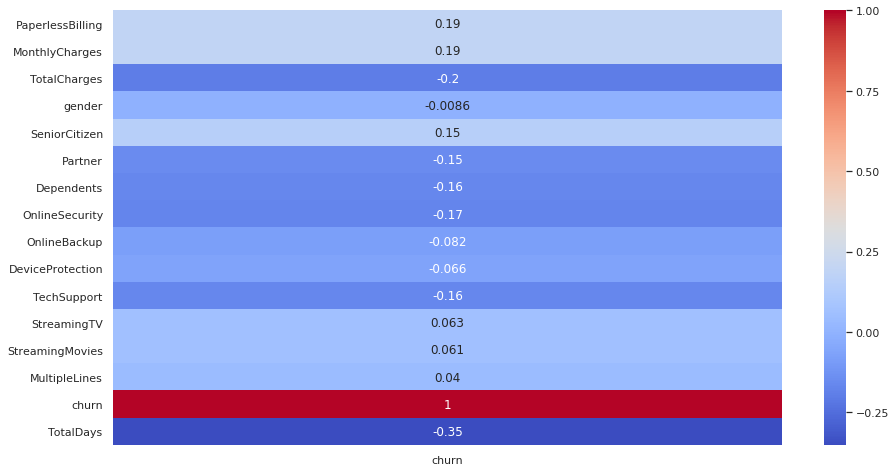

In [32]:
sns.set(rc = {'figure.figsize':(15,8)})
sns.heatmap(df_final.corr()[['churn']], annot = True, cmap = 'coolwarm')

Выведем корреляцию между количественными данными

In [33]:
df_final[num_col].corr()

,MonthlyCharges,TotalCharges,TotalDays
MonthlyCharges,1.000000,0.651174,0.247754
TotalCharges,0.651174,1.000000,0.826109
TotalDays,0.247754,0.826109,1.000000


Корреляция между TotalCharges и TotalDays - 0.82, чем дольше клиент платит, тем больше итоговая сумма. Удалим поле TotalCharges

In [34]:
del df_final['TotalCharges']
num_col = ['MonthlyCharges', 'TotalDays']

#### Вывод по исследовательскому анализу

1. Наибольшую склонность к оттоку имеют клиенты, использующие ежемесячный способ оплаты и клиенты, которые используют электронные чеки
2. Дополнительные услуги не существенно влияют на отток клиентов. Клиенты уходят примерно в равном соотношении
3. Пенсионеры покидают сервис гораздо реже. Так же реже покидают сервис и те, кто не пользуетя интернетом. Скорее всего это люди одной категории и им трудно разбираться в том, как сменить поставщика услуг

### Подготовка данных для моделей

Для преобразования категоральных признаков в численные применим технику One-Hot Encoding

In [35]:
df_final = pd.get_dummies(df_final, drop_first=True)

In [36]:
df_final.head()

,PaperlessBilling,MonthlyCharges,gender,SeniorCitizen,Partner,Dependents,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,...,MultipleLines,churn,TotalDays,Type_One year,Type_Two year,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,InternetService_Fiber optic,InternetService_No
0,1,29.85,0,0,1,0,0,1,0,0,...,0,0,31,0,0,0,1,0,0,0
1,0,56.95,1,0,0,0,1,0,1,0,...,0,0,1036,1,0,0,0,1,0,0
2,1,53.85,1,0,0,0,1,1,0,0,...,0,1,61,0,0,0,0,1,0,0
3,0,42.30,1,0,0,0,1,0,1,1,...,0,0,1371,1,0,0,0,0,0,0
4,1,70.70,0,0,0,0,0,0,0,0,...,0,1,61,0,0,0,1,0,1,0


Определим фичи и целевой признак Churn, после чего разделим датафрейм на обучающую и тестовую выбороки. 

In [37]:
target = df_final['churn'] 
features = df_final.drop(columns=['churn'])

In [38]:
features_train, features_test, target_train, target_test = train_test_split(features, target, test_size=0.2, 
                                                                            random_state=12345)

Проведем масштабирование количественных признаков

In [39]:
scaler = StandardScaler()

scaler.fit(features_train[num_col])

features_train = features_train.copy()
features_train[num_col] = scaler.transform(features_train[num_col])

features_test = features_test.copy()
features_test[num_col] = scaler.transform(features_test[num_col])

Посмотрим на баланс классов

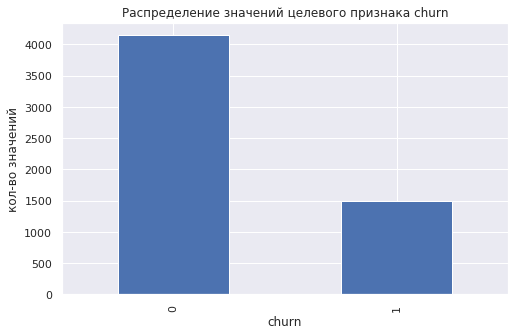

In [40]:
target_train.value_counts().plot(
    kind='bar', 
    figsize=(8, 5),
    legend=False, 
    title='Распределение значений целевого признака churn', 
).set(xlabel='churn', ylabel='кол-во значений')
plt.show()

In [150]:
ratio = target_train[target_train == 1].count() / target_train[target_train == 0].count()
ratio

0.35955598455598453

Присутсвует дисбаланс классов, необходимо увеличить число объектов меньшего класса. Применим технику upsampling

In [41]:
def upsample(features, target, repeat):     
    features_zeros = features[target == 0]     
    features_ones = features[target == 1]     
    target_zeros = target[target == 0]     
    target_ones = target[target == 1] 

    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)     
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)     
    
    features_upsampled, target_upsampled = shuffle(         
        features_upsampled, target_upsampled, random_state=12345)          
    
    return features_upsampled, target_upsampled

In [42]:
features_train, target_train = upsample(features_train, target_train, 3)

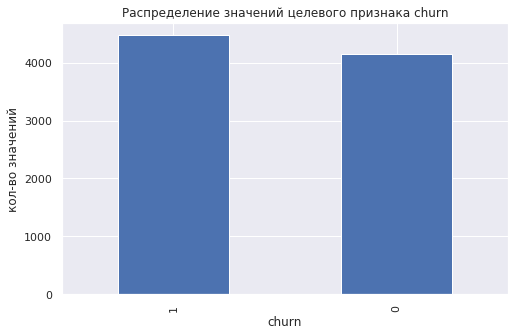

In [43]:
target_train.value_counts().plot(
    kind='bar', 
    figsize=(8, 5),
    legend=False, 
    title='Распределение значений целевого признака churn', 
).set(xlabel='churn', ylabel='кол-во значений')
plt.show()

Теперь значения целевого признака находятся примерно в равных соотношениях

### Обучение моделей


Создадим функцию для расчета ROC-AUC score и построения ROC-AUC кривой

In [44]:
def plot_roc_curve(target_test, predictions):
    print('ROC-AUC score', roc_auc_score(target_test, predictions))
    
    fpr, tpr, thresholds = roc_curve(target_test, predictions)

    plt.figure(figsize=(11, 5))
    
    plt.plot(fpr, tpr)
    
    plt.plot([0, 1], [0, 1], linestyle='--')
    
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    
    plt.title('ROC-кривая')
    
    plt.show()

##### LogisticRegression


In [45]:
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}

model = LogisticRegression(solver='lbfgs', n_jobs=-1)

search = GridSearchCV(model, param_grid, cv=5, scoring='roc_auc')
search.fit(features_train, target_train)

print(search.best_params_)

predicted_probalities = search.best_estimator_.predict_proba(features_test)[:, 1]

{'C': 100}


ROC-AUC score 0.8437636088838795


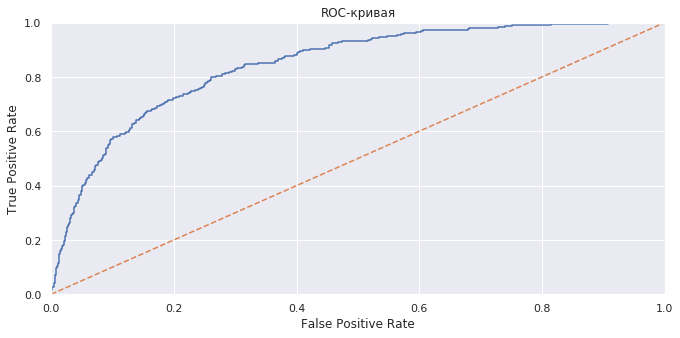

In [46]:
plot_roc_curve(target_test, predicted_probalities)


##### RandomForestClassifier


In [47]:
param_grid = {
    'max_depth': [5, 10, 20],
    'min_samples_split': [2, 10],
    'min_samples_leaf': [2, 10],
    'n_estimators': [10, 50, 100], 
}

model = RandomForestClassifier(random_state=12345)

search = GridSearchCV(model, param_grid, cv=5, scoring='roc_auc')
search.fit(features_train, target_train)

print(search.best_params_)

predicted_probalities = search.best_estimator_.predict_proba(features_test)[:, 1]

{'max_depth': 20, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100}


ROC-AUC score 0.8454504700668597


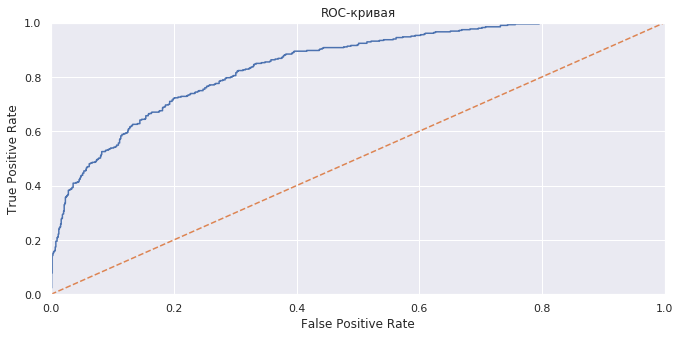

In [48]:
plot_roc_curve(target_test, predicted_probalities)

##### CatBoostClassifier


In [49]:
param_grid = {
    'learning_rate': [0.1, 0.3],
    'iterations': [50, 100],
    'l2_leaf_reg': [3, 9]
}

model = CatBoostClassifier(random_state=12345, verbose=0)

search = GridSearchCV(model, param_grid, cv=5, scoring='roc_auc')
search.fit(features_train, target_train)

print(search.best_params_)

predicted_probalities = search.best_estimator_.predict_proba(features_test)[:, 1]

{'iterations': 100, 'l2_leaf_reg': 3, 'learning_rate': 0.3}


ROC-AUC score 0.909758690473141


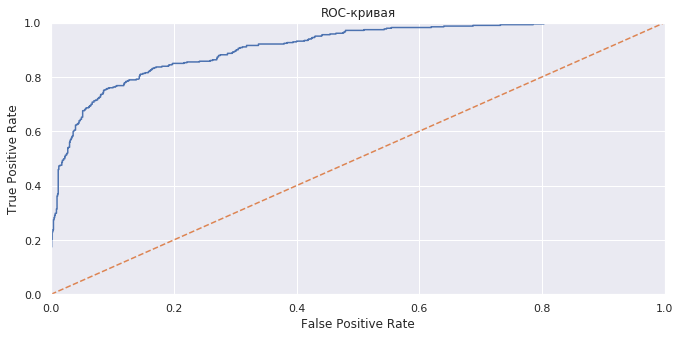

In [50]:
plot_roc_curve(target_test, predicted_probalities)

Catboost показал наилучшее значение метрики ROC-AUC - 0.91
Вычилим важность факторов

In [51]:
importances_df = pd.DataFrame(search.best_estimator_.feature_importances_, index = features_test.columns, columns=['importances'])
importances_df = importances_df.sort_values(by='importances', ascending=False)
importances_df

,importances
TotalDays,58.407544
MonthlyCharges,10.905146
Type_Two year,3.930785
InternetService_Fiber optic,3.506221
Type_One year,2.050189
InternetService_No,1.896641
PaymentMethod_Mailed check,1.790540
PaperlessBilling,1.619544
TechSupport,1.609179
PaymentMethod_Electronic check,1.588030


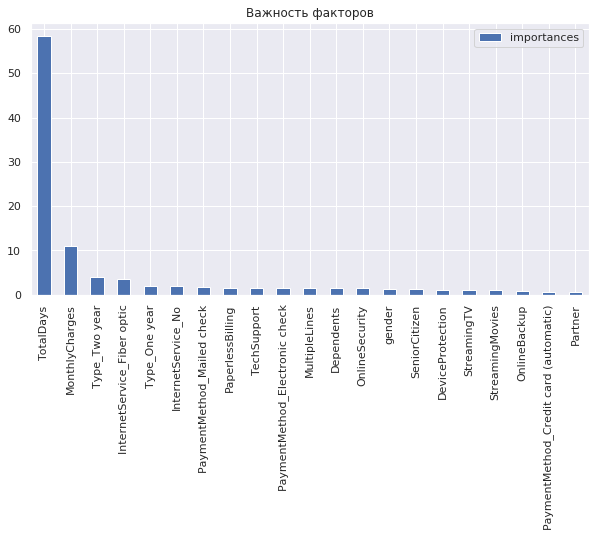

In [52]:
importances_df.plot(kind='bar', figsize=(10, 5), title='Важность факторов')
plt.show()

In [53]:
index = ['LinearRegression',
         'RandomForestRegressor',
         'CatBoostRegressor']
data = {' ROC-AUC':[0.84, 0.85, 0.91]}
scores_data = pd.DataFrame(data=data, index=index)
scores_data

,ROC-AUC
LinearRegression,0.84
RandomForestRegressor,0.85
CatBoostRegressor,0.91


### Вывод

- Произведена первичная обработка данных - переименованы столбцы, изменены типы данных
- Определен целевой признак Churn, отражающий факт отказа клиента от услуг и признак TotalDays, который обозначает сколько по времени пользователь пользовался услугами
- Проведен исследовательский анализ данных - проанализированы количественные и категоральные признаки, проведена попытка найти связь между ними и целевым признаком. По ходу исследовательского анализа были сделаны следующие выводы: 
    - Наибольшую склонность к оттоку имеют клиенты, использующие ежемесячный способ оплаты и клиенты, которые используют электронные чеки
    - Дополнительные услуги не существенно влияют на отток клиентов. Клиенты уходят примерно в равном соотношении
    - Пенсионеры покидают сервис гораздо реже. Так же реже покидают сервис и те, кто не пользуетя интернетом. Скорее всего это люди одной категории и им трудно разбираться в том, как сменить поставщика услуг
- Проведена подготовка данных к обучению моделей: удалены ненужные столбцы, применена техника OHE, датафрейм был разделен на обучающую и тестовую выборки, проведено масштабирование количественных признаков и увеличение числа объектов меньшего класса целевого признака техникой upsample
- Были обучены 3 модели: LogisticRegression, RandomForestClassifier и CatBoostClassifier. Лучший результат показала модель CatBoostClassifier со значением метрики ROC-AUC в 0.91
- Самыми значимыми факторами являются показатели того, сколько клиент пользуется услугами и сколько он платит в месяц